In [19]:
from IPython.display import HTML

HTML('''
<style>
button#toggleButton {
    background-color:#e6e6e6;
    border:1px solid #aaa;
    padding:6px;
    border-radius:5px;
    cursor:pointer;
}
</style>

<script>
code_visible = true;

function toggle_code() {
    code_cells = document.querySelectorAll('.code_cell .input');
    code_visible = !code_visible;
    for (let cell of code_cells) {
        cell.style.display = code_visible ? 'block' : 'none';
    }
    document.getElementById("toggleButton").innerHTML = code_visible ? "👀 隠す" : "📄 コードを表示";
}
</script>

<button id="toggleButton" onclick="toggle_code()">👀 隠す</button>
''')


# Disaster Data Analysis – Functions と Loop を使った可視化

この Notebook では、`emdat.csv` を用いて世界の災害データを分析する。  
課題要件である以下の 3 点を満たすことを目的とする。

1. 自作の Function（関数）
2. 関数を使ったサンプル出力
3. Loop（for 文）による複数グラフの可視化

最終的に、災害タイプごとの死亡者数の違いや年代ごとの傾向について考察する。


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# ---- 日本語フォント設定（Windows） ----
font_path = r"C:\Windows\Fonts\YuGothM.ttc"
fm.fontManager.addfont(font_path)

plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams["axes.unicode_minus"] = False

print("使用中フォント:", plt.rcParams["font.family"])


使用中フォント: ['Yu Gothic']


## 1. データ読み込みと前処理


In [21]:
df = pd.read_csv("emdat.csv")
df["Total Deaths"] = df["Total Deaths"].fillna(0)

type_jp = {
    "Flood": "洪水", "Earthquake": "地震", "Epidemic": "感染症",
    "Drought": "干ばつ", "Storm": "嵐", "Volcanic activity": "火山活動",
    "Wildfire": "山火事", "Extreme temperature": "異常気温",
    "Mass movement (dry)": "地すべり（乾燥）", "Mass movement (wet)": "地すべり（湿潤）",
    "Infestation": "害虫被害", "Impact": "衝突災害",
    "Animal incident": "動物被害", "Fog": "濃霧",
    "Glacial lake outburst flood": "氷河湖決壊洪水"
}

df["災害タイプ"] = df["Disaster Type"].replace(type_jp)
df["Decade"] = (df["Start Year"] // 10) * 10

df.head()


,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Subregion,Region,Latitude,Longitude,Start Year,Total Deaths,災害タイプ,Decade
0,Meteorological,Storm,Tropical cyclone,USA,United States of America,Northern America,Americas,NaN,NaN,1900,6000.0,嵐,1900
1,Hydrological,Flood,Flood (General),JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,300.0,洪水,1900
2,Biological,Epidemic,Viral disease,JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,30.0,感染症,1900
3,Geophysical,Volcanic activity,Ash fall,JPN,Japan,Eastern Asia,Asia,NaN,NaN,1900,30.0,火山活動,1900
4,Geophysical,Earthquake,Ground movement,TUR,Türkiye,Western Asia,Asia,40.3,43.1,1900,140.0,地震,1900


## 2. 関数の作成
指定した災害タイプの総死亡者数を返す関数を定義する。


In [22]:
def total_deaths_by_type(dataframe, dtype):
    return dataframe[dataframe["災害タイプ"] == dtype]["Total Deaths"].sum()


### 🔍 関数の動作確認


In [23]:
for t in ["洪水", "地震", "干ばつ", "感染症"]:
    print(f"{t}：{total_deaths_by_type(df, t):,}人")


洪水：7,016,630.0人
地震：2,409,975.0人
干ばつ：11,734,272.0人
感染症：9,623,111.0人


## 3. Loop を使った複数グラフの可視化

災害タイプごとに年間死亡者数の変化を折れ線グラフで表示する。


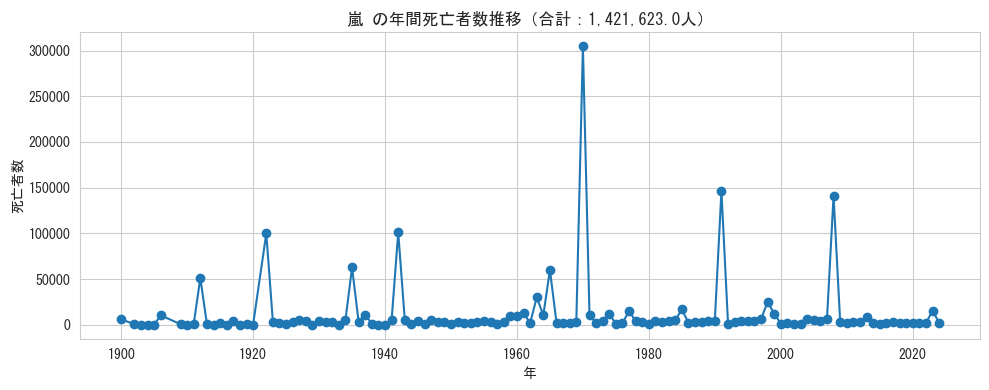

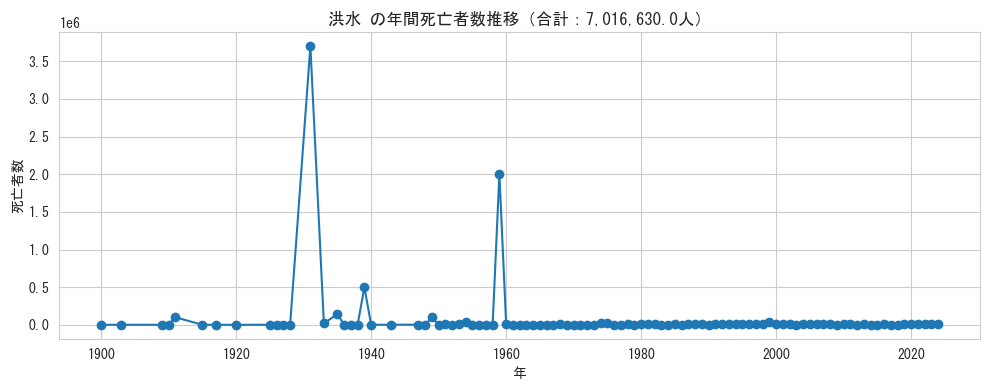

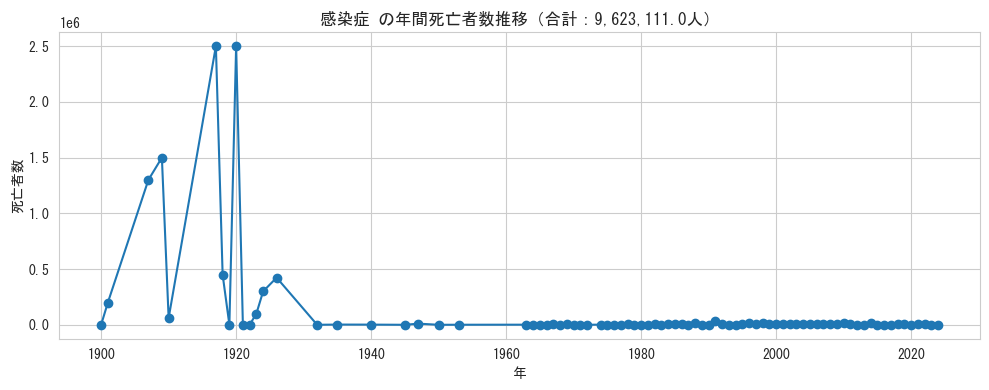

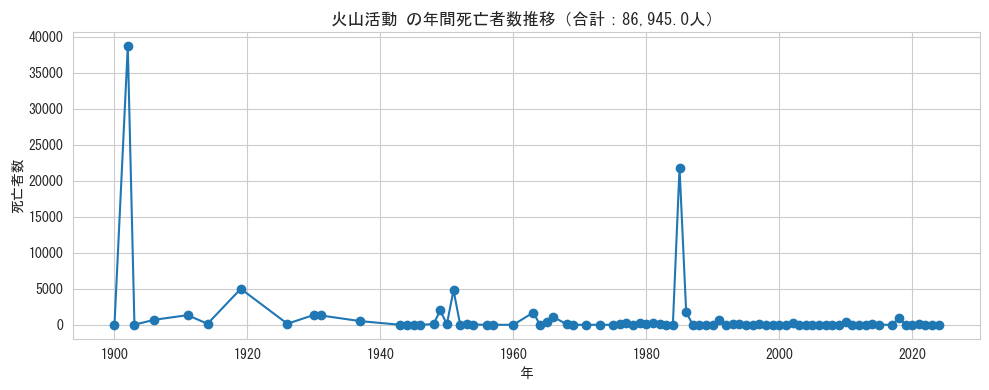

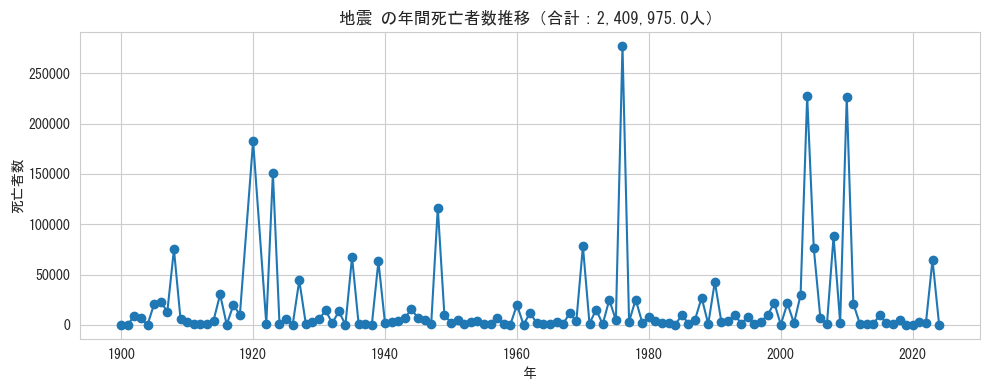

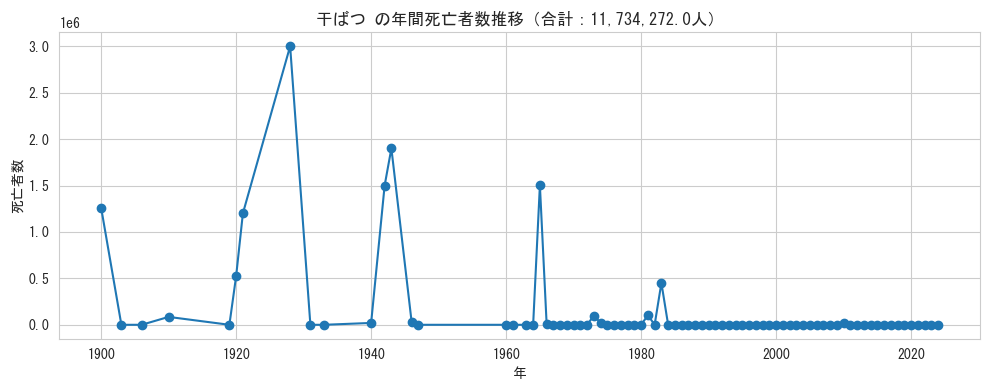

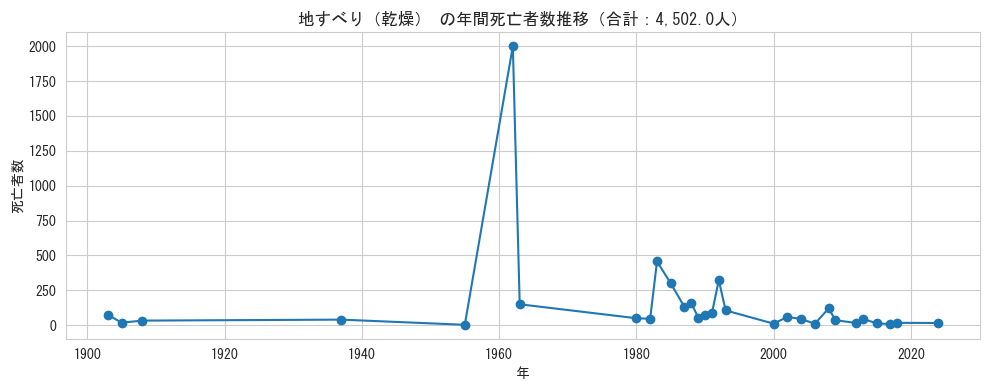

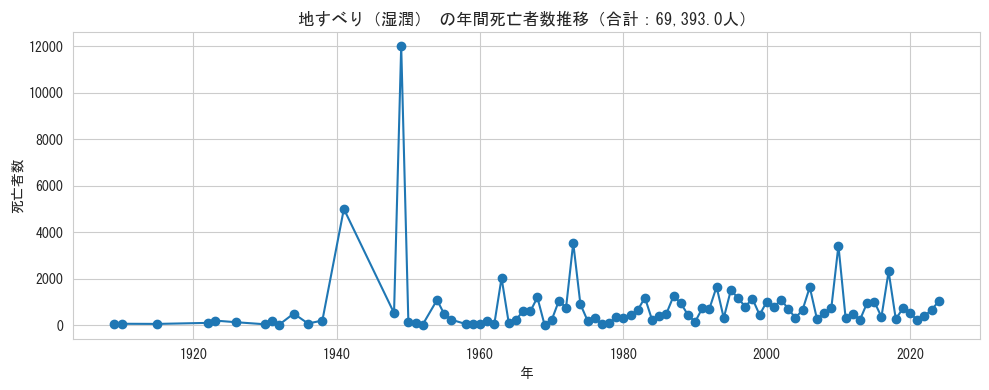

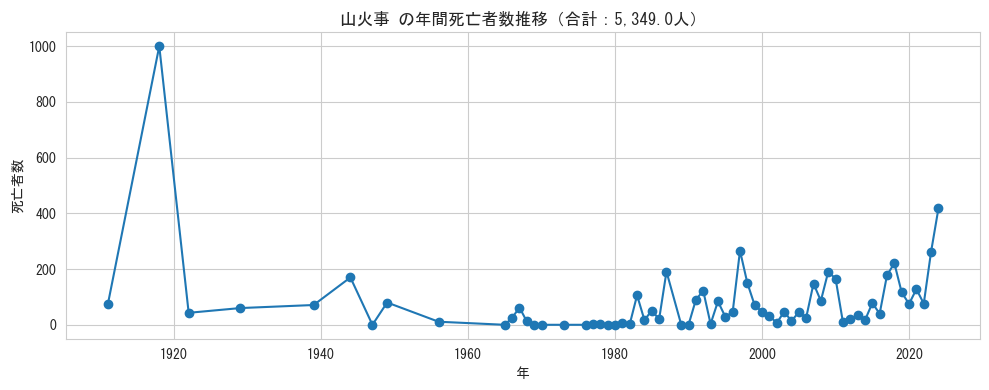

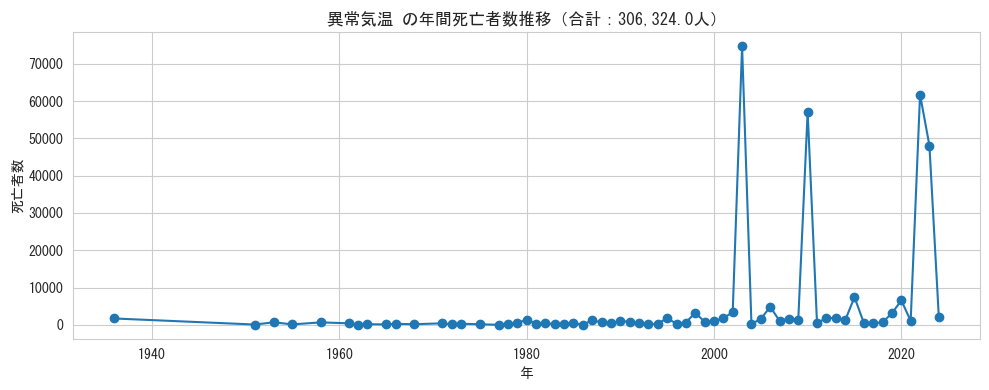

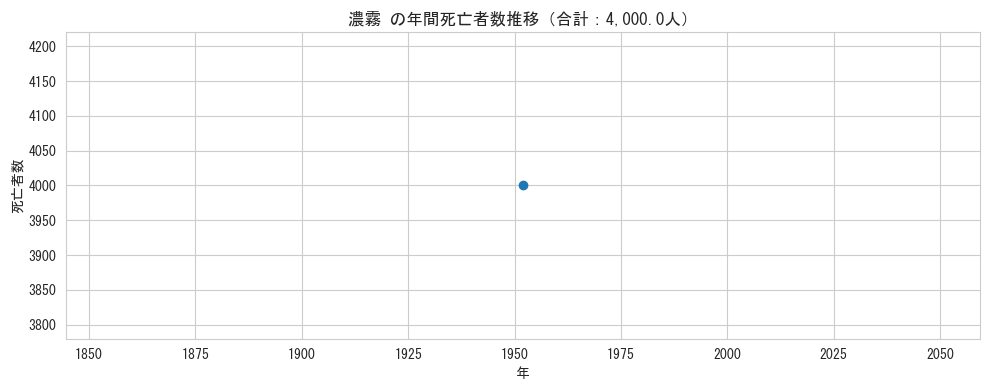

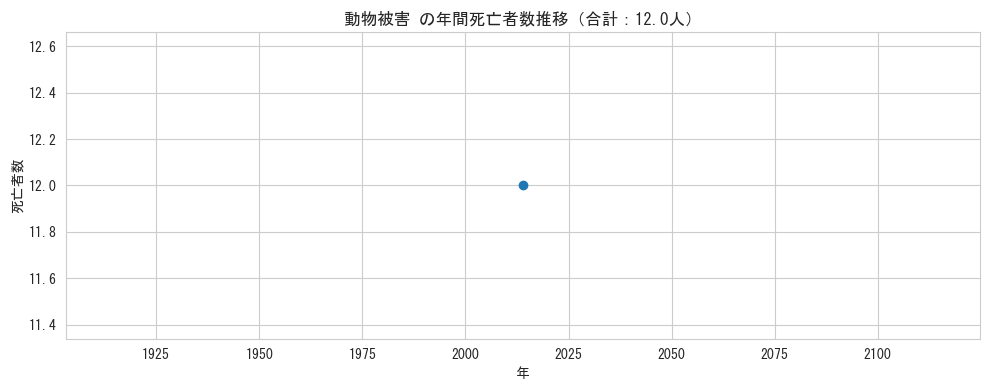

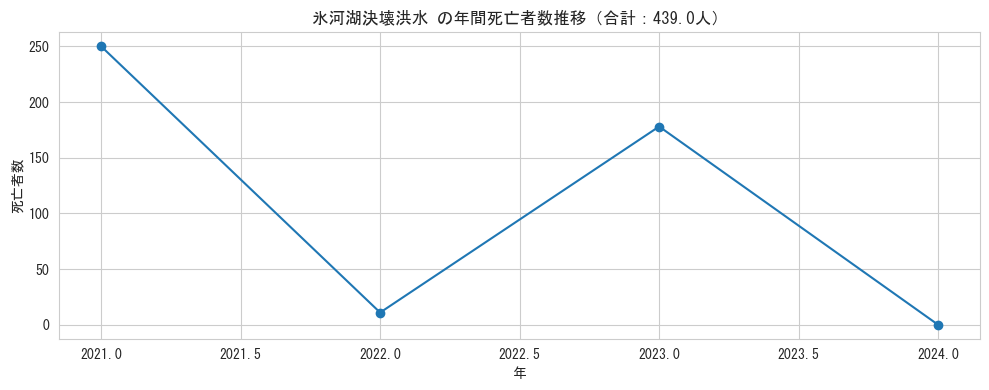

In [24]:
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'MS Gothic'   # Windowsならこれが最適

for dtype in df["災害タイプ"].unique():
    yearly = df[df["災害タイプ"] == dtype].groupby("Start Year")["Total Deaths"].sum()
    if yearly.sum() == 0:
        continue
    
    plt.figure(figsize=(10, 4))
    plt.plot(yearly.index, yearly.values, marker="o")
    plt.title(f"{dtype} の年間死亡者数推移（合計：{yearly.sum():,}人）")
    plt.xlabel("年")
    plt.ylabel("死亡者数")
    plt.tight_layout()
    plt.show()


## 4. 災害別死亡者数ランキング
TOP10を横棒グラフで可視化する。


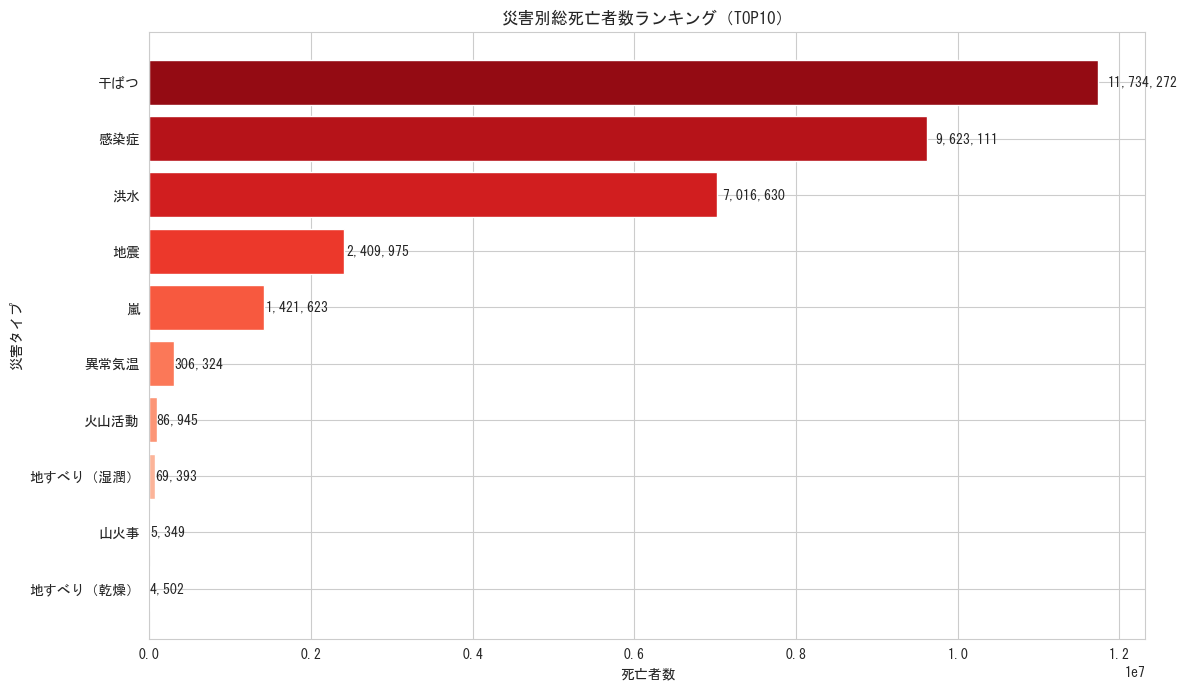

In [25]:
death_by_type = df.groupby("災害タイプ")["Total Deaths"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
colors = sns.color_palette("Reds", len(death_by_type))[::-1]
bars = plt.barh(death_by_type.index, death_by_type.values, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width * 1.01, bar.get_y() + bar.get_height() / 2, f"{int(width):,}", va="center")

plt.title("災害別総死亡者数ランキング（TOP10）")
plt.xlabel("死亡者数")
plt.ylabel("災害タイプ")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 5. 年代 × 災害ヒートマップ


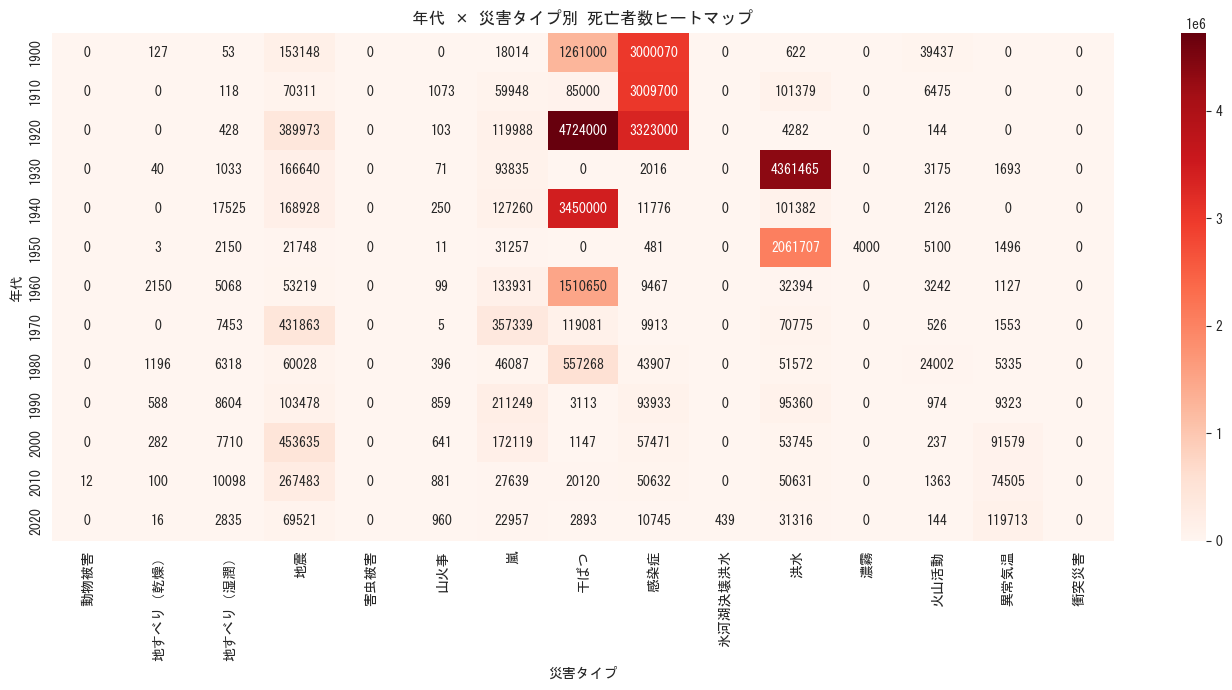

In [26]:
pivot = df.pivot_table(index="Decade", columns="災害タイプ", values="Total Deaths", aggfunc="sum").fillna(0)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f")
plt.title("年代 × 災害タイプ別 死亡者数ヒートマップ")
plt.xlabel("災害タイプ")
plt.ylabel("年代")
plt.tight_layout()
plt.show()


## 6. 考察

今回の分析から、災害タイプごとに死亡者数の規模や年代による差が大きいことが確認できた。

- **干ばつ・感染症・洪水・地震**の死亡者数が非常に大きく、災害リスク対策における重要カテゴリである。
- 特定の年代に死亡者数が集中する災害が多く、単一イベントが統計全体に強く影響している可能性がある。
- 一方で「動物被害」「濃霧」などは死亡者数が少なく、影響範囲が限定的であると考えられる。

以上より、災害対策の優先順位付けや防災政策の議論において、災害種別の死亡影響分析が有用であることが示唆される。
